_BloomTech Data Science, Unit 2_

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [1]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders

In [2]:
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
import pandas as pd
import numpy as np


# Sprint Challenge: Predict Steph Curry's Shots 🏀

For your Sprint Challenge, you'll use a dataset with all Steph Curry's NBA field goal attempts from October 2009 through June 2019 (regular season and playoffs). The dataset was collected with the [nba_api](https://github.com/swar/nba_api) Python library.

You'll create a model to predict whether Curry will make a shot based on his past perfomance.

# Directions

This notebook contains 10 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Importing data.
- **Task 2:** Feature engineering.
- **Task 3:** Splitting data into a feature matrix and target vector.
- **Task 4:** Splitting data into training, validation, and test sets.
- **Task 5:** Establishing baseline accuracy.
- **Task 6:** Building a model with a transformer and a tree-based predictor.
- **Task 7:** Calculating training and validation accuracy.
- **Task 8 (`stretch goal`):** Tuning model hyperparameters.
- **Task 9:** Calculating precision and recall from a confusion matrix.
- **Task 10 (`stretch goal`):** Plotting a confusion matrix.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise
NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`



# I. Wrangle Data

**Task 1:** Change the code below to import your dataset. Be sure to examine the columns carefully and determine if one of them should be set at the index.

In [17]:
df.shape

(13958, 20)

In [109]:
'''T1. Import DataFrame `df`'''

# import pandas as pd
url = 'https://drive.google.com/uc?export=download&id=1fL7KPyxgGYfQDsuJoBWHIWwCAf-HTFpX'
# df = pd.read_csv(url)
# YOUR CODE HERE
def wrangle(filepath):
  df = pd.read_csv(filepath,
              parse_dates = ['game_date'],
              index_col = 'game_date'
              )

  df['home_game'] = df['htm'] == 'GSW'
  df['home_game'] = df['home_game'].astype(int)
  df['seconds_remaining_in_q'] = df['minutes_remaining'] * 60 + df['seconds_remaining']
  quarters_left = 4 - df['period']
  df['seconds_remaining_in_game'] = ((quarters_left * 12) * 60) + df['seconds_remaining_in_q']
  df['made_prev'] = df['shot_made_flag'].shift(1)
  df['made_prev'].fillna(0, inplace = True)

  df.drop(columns = ['player_name'],inplace = True)
  cutoff = 80
  drop_cols = [col for col in df.select_dtypes('object').columns
               if df[col].nunique() > cutoff]
  df.drop(columns = drop_cols, inplace = True)

  dupe_cols = [col for col in df.head(100).T.duplicated().index
                 if df.head(100).T.duplicated()[col]]
  df.drop(columns=dupe_cols, inplace=True)

  return df
df = wrangle(url)

In [88]:
type(df.index)

pandas.core.indexes.range.RangeIndex

In [116]:
df.head(15)

,game_id,game_event_id,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,...,loc_y,shot_made_flag,htm,vtm,season_type,scoremargin_before_shot,home_game,seconds_remaining_in_q,seconds_remaining_in_game,made_prev
game_date,,,,,,,,,,,,,,,,,,,,,
2009-10-28,20900015,4,1,11,25,Jump Shot,3PT Field Goal,Above the Break 3,Right Side Center(RC),24+ ft.,...,249,0,GSW,HOU,Regular Season,2.0,1,685,2845,0.0
2009-10-28,20900015,17,1,9,31,Step Back Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,...,145,1,GSW,HOU,Regular Season,0.0,1,571,2731,0.0
2009-10-28,20900015,53,1,6,2,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),8-16 ft.,...,129,0,GSW,HOU,Regular Season,-4.0,1,362,2522,1.0
2009-10-28,20900015,141,2,9,49,Jump Shot,2PT Field Goal,Mid-Range,Left Side(L),16-24 ft.,...,82,0,GSW,HOU,Regular Season,-4.0,1,589,2029,0.0
2009-10-28,20900015,249,2,2,19,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,...,148,0,GSW,HOU,Regular Season,0.0,1,139,1579,0.0
2009-10-28,20900015,277,2,0,34,Jump Shot,2PT Field Goal,In The Paint (Non-RA),Center(C),Less Than 8 ft.,...,15,0,GSW,HOU,Regular Season,4.0,1,34,1474,0.0
2009-10-28,20900015,413,4,10,26,Pullup Jump shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,...,149,1,GSW,HOU,Regular Season,-9.0,1,626,626,0.0
2009-10-28,20900015,453,4,6,31,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,...,123,1,GSW,HOU,Regular Season,-6.0,1,391,391,1.0
2009-10-28,20900015,487,4,2,25,Pullup Jump shot,2PT Field Goal,Mid-Range,Right Side Center(RC),16-24 ft.,...,162,1,GSW,HOU,Regular Season,-9.0,1,145,145,1.0


**Task 1 Testing**

In [106]:
'''T1 Testing'''

assert isinstance(df, pd.DataFrame), 'Have you created a DataFrame named `df`?'
assert len(df) == 13958, 'Is `df` the correct length?'


**Task 2a:** Engineer at least 1 new feature. You can use something from the list below or your own idea.

- **Homecourt Advantage**: Is the home team (`htm`) the Golden State Warriors (`GSW`) ?
- **Opponent**: Who is the other team playing the Golden State Warriors?
- **Seconds remaining in the period**: Combine minutes remaining with seconds remaining, to get the total number of seconds remaining in the period.
- **Seconds remaining in the game**: Combine period, and seconds remaining in the period, to get the total number of seconds remaining in the game. A basketball game has 4 periods, each 12 minutes long.
- **Made previous shot**: Was Steph Curry's previous shot successful?

**Task 2b (`stretch goal — optional`):** Create a total of 3 new features, using your own ideas or the list above. Make sure you're not just duplicating features that are already in the feature matrix.

In [ ]:
"""T2. Create new feature"""

# YOUR CODE HERE
raise NotImplementedError()

**Task 2 Test**

In [111]:
'''T2 Testing'''

assert df.shape[1] >= 20, '`df` does not appear to have new features.'


# II. Split Data

**Task 3:** Divide the DataFrame `df` into the feature matrix `X` and the target vector `y`. Your target is `'shot_made_flag'`.

In [114]:
'''T3. Create `X` and `y`.'''
# YOUR CODE HERE
X = df.drop(columns = 'shot_made_flag')
y = df['shot_made_flag']

**Task 3 Test**

In [115]:
'''T3 Tests'''

assert y.shape == (13958,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert len(X) == 13958, '`X` has the wrong number of rows.'
assert X.shape[1] > 1, '`X` has the wrong number of columns'
assert 'shot_made_flag' not in X.columns, 'Target is still part of feature matrix.'

**Task 4:** Divide your dataset into training, validation, and test sets.

- Your training set (`X_train`, `y_train`) should contain games from the 2009-10 season through the end of the 2016-17 season.
- Your validation set (`X_val`, `y_val`) should contain games from the 2017-18 season.
- Your test set (`X_test`, `y_test`) should contain games from the 2018-2019 season.
- **Tip:** The NBA season begins in October and ends in June.

In [136]:
'''T4. Create training and val'''
# YOUR CODE HERE
val_cutoff = '2017-09-01'
test_cutoff = '2018-09-01'

test_mask = X.index > test_cutoff
val_mask = (X.index > val_cutoff) & (X.index <= test_cutoff)

X_test = X[test_mask]
y_test = y[test_mask]

X_val = X[val_mask]
y_val = y[val_mask]

X_train = X[~(test_mask | val_mask)]
y_train = y[~(test_mask | val_mask)]

X_train.shape,y_train.shape

((11081, 21), (11081,))

**Test 4**

In [134]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 11081
assert len(X_val) == len(y_val) == 1168
assert len(X_test) == len(y_test) == 1709


# III. Establish Baseline

**Task 5:** Establish the baseline accuracy score for this classification problem using your training set. Save the score to the variable `baseline_acc`.

In [143]:
'''T5. Calculate baseline accuracy `baseline_acc`.'''

# YOUR CODE HERE
baseline_acc = y_train.value_counts(normalize = True).max()
print('Baseline Accuracy:', baseline_acc)

Baseline Accuracy: 0.5272087356736757


**Task 5 Testing**

In [144]:
'''T5 Testing'''

assert isinstance(baseline_acc, float)
assert 0.0 <= baseline_acc <= 1.0


# IV. Build Model

**Task 6:** Build a model that includes (1) a transformer for categorical features and (2) a tree-based predictor. You should combine these two components (and any other pieces you think are necessary) in a pipeline named `model`. Be sure to fit your model to your training data.

In [146]:
'''T6. Build a pipeline `model` with encoder and tree-based predictor.'''

# YOUR CODE HERE
model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        n_jobs = -1,
        random_state = 42
    )
)
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
Pullup Jump shot                       3
Layup Shot                             4
Jump Bank Shot                         5
Driving Layup Shot                     6
Reverse Layup Shot                     7
Running Jump Shot                      8
Floating Jump...
                                          'mapping': HOU     1
GSW     2
MEM     3
LAC     4
MIN     5
POR     6
LAL     7
IND     8
ORL     9
SAS    10
WAS    11
PHX    12
BOS    13
SAC    14
CLE    15
MIA    16
MIL    17
CHI    18
DEN    19
NJN    20
NOH    21
CHA    22
OKC    23
DAL    24
UTA    25
ATL    26
PHI    27
DET    28
TOR    29
NYK    30
BKN    31
NOP    32
NaN    -2
dtype: int64},
                                         {'col': 'season_type',
                                          'data_type': dtype('O'),
                                          'mapping': Regular Season    1
Playoffs          2
NaN              -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(n_jobs=-1, random_state=42))])

**Task 6 Testing**

In [147]:
'''T6 Testing'''

from sklearn.pipeline import Pipeline
assert isinstance(model, Pipeline), '`model` should be type `Pipeline`.'

# Does `model` Pipeline have multiple components?
assert len(model.named_steps.keys()) > 1, '`model` should have more than one component.'

# Has `model` been trained?
assert hasattr(model, 'classes_'), 'Have you trained `model`?'


# V. Check Metrics

**Task 7:** Check the training and validation accuracy of your model, and assign the scores to `train_acc` and `val_acc` respectively.

In [148]:
'''T7. Calculate train and test accuracy.'''

# YOUR CODE HERE
train_acc = model.score(X_train, y_train)
val_acc = model.score(X_val, y_val)
print('Training Accuracy Score:', train_acc)
print('Validation Accuracy Score:', val_acc)

Training Accuracy Score: 1.0
Validation Accuracy Score: 0.5916095890410958


**Task 7 Test**

In [149]:
'''T7 Testing'''

# Is `training_acc` a float between 0.0 and 1.0?
assert isinstance(train_acc, float)
assert 0.0 <= train_acc <= 1.0

# Is `validation_acc` a float between 0.0 and 1.0?
assert isinstance(val_acc, float)
assert 0.0 <= val_acc <= 1.0


# VI. Tune Model

**Task 8 (`stretch goal — optional`):** Using your training and validation sets as a guide, tune the hyperparameters of your model to see if you can improve its accuracy. You can perform your tuning "by hand" or using [`RandomizedSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

- Important hyperparameters for all tree-based models: `max_depth`.
- Important hyperparameters for random forest models: `n_estimators`, `max_samples`.
- Important hyperparametes for gradient boosting tree models: `n_estimators`, `learning_rate`.
- **TIP:** If you use `RandomizedSearchCV`, set `n_iter` to `3`. Any larger and the auto-grader will stop working.
- **TIP:** Since you already created a validation set above, there is no need to do k-fold cross-validation here. Set `cv` to `None`.

Once you're satisfied with your model's performance on the validation set (if you can get above `0.6`, you're doing good), calculate its accuracy with your test set. Assign the result to `test_acc`.

In [164]:
'''T8. Tune model.'''

# YOUR CODE HERE
clf_rf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier()
)
param_grid = {
    'randomforestclassifier__max_depth':range(5,75,5),
    'randomforestclassifier__n_estimators':range(10,250,10),
    'randomforestclassifier__min_samples_split':range(2,4,1),
    'randomforestclassifier__min_samples_leaf':range(1,3,1),
    'randomforestclassifier__max_samples':range(25,100,5)
}
model_tune = RandomizedSearchCV(
    clf_rf,
    param_distributions= param_grid,
    n_jobs = -1,
    verbose = 1,
    n_iter = 3,
    cv = None
)
model_tune.fit(X_train,y_train)


test_acc = model_tune.best_score_
print('Testing Accuracy Score:', test_acc)
print(model_tune.best_params_)

Fitting 5 folds for each of 35 candidates, totalling 175 fits
Testing Accuracy Score: 0.6286425536834667
{'randomforestclassifier__n_estimators': 150, 'randomforestclassifier__min_samples_split': 3, 'randomforestclassifier__min_samples_leaf': 2, 'randomforestclassifier__max_samples': 80, 'randomforestclassifier__max_depth': 70}


In [186]:
model = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(
        n_jobs = -1,
        random_state = 42,
        n_estimators= 150,
        min_samples_leaf= 2,
        min_samples_split= 3,
        max_depth=70,
        max_samples = 300
    )
)
model.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['action_type', 'shot_type',
                                      'shot_zone_basic', 'shot_zone_area',
                                      'shot_zone_range', 'htm', 'vtm',
                                      'season_type'],
                                mapping=[{'col': 'action_type',
                                          'data_type': dtype('O'),
                                          'mapping': Jump Shot                              1
Step Back Jump shot                    2
Pullup Jump shot                       3
Layup Shot                             4
Jump Bank Shot                         5
Driving Layup Shot                     6
Reverse Layup Shot                     7
Running Jump Shot                      8
Floating Jump...
CHI    18
DEN    19
NJN    20
NOH    21
CHA    22
OKC    23
DAL    24
UTA    25
ATL    26
PHI    27
DET    28
TOR    29
NYK    30
BKN    31
NOP    32
NaN    -2
dtype: int64},
                                         {'col': 'season_type',
                                          'data_type': dtype('O'),
                                          'mapping': Regular Season    1
Playoffs          2
NaN              -2
dtype: int64}])),
                ('randomforestclassifier',
                 RandomForestClassifier(max_depth=70, max_samples=300,
                                        min_samples_leaf=2, min_samples_split=3,
                                        n_estimators=150, n_jobs=-1,
                                        random_state=42))])

In [187]:
model.score(X_train,y_train),model.score(X_val,y_val)

(0.6730439491020666, 0.6061643835616438)

**Task 8 Testing**

In [177]:
'''T8 Testing'''
assert isinstance(test_acc, float)
assert 0.0 <= test_acc <= 1.0

# VII. Communication

**Task 9:** Below is a confusion matrix for the model that your instructor made for this challenge (based on the **test data**). Calculate the precision and recall of this model, naming them `instructor_precision` and `instructor_recall`, respectively.

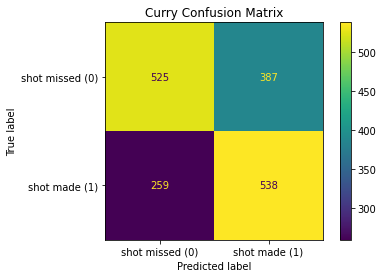

In [179]:
'''T9. Calculate precision and recall'''
# YOUR CODE HERE
instructor_precision = 538 / (538 + 387)
instructor_recall = 538 / (538 + 259)
print('Instuctor model precision', instructor_precision)
print('Instuctor model recall', instructor_recall)

Instuctor model precision 0.5816216216216217
Instuctor model recall 0.6750313676286073


**Task 9 Testing**

In [180]:
'''T9 Testing'''
assert isinstance(instructor_precision, float)
assert isinstance(instructor_recall, float)
assert 0 <= instructor_precision <= 1
assert 0 <= instructor_recall <= 1

**Task 10 (`stretch goal — optional`):** Plot confusion matrix for your model using your **test data**.

This task will not be autograded - but it is part of completing the challenge.

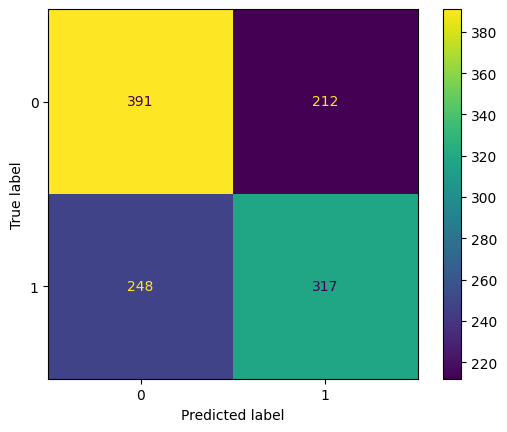

In [188]:
'''T10. Plot ROC curve.'''
# YOUR CODE HERE
plot_confusion_matrix = ConfusionMatrixDisplay.from_estimator

plot_confusion_matrix(
    model,
    X_val,
    y_val
);